first we need to define our model, and first thing is finding frictions and with zero motor acceleration.

In [16]:
# from Digital_twin import DigitalTwin
# import Digital_twin 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
# theta = 1
# theta_dot = 0

# theta_double_dot = digital_twin_instance.get_theta_double_dot(theta, theta_dot)

In [ ]:
# print(digital_twin_instance.delta_t)

In [6]:
half_theta_2 = pd.read_csv('Half_theta_2.csv')
df = half_theta_2

acc_x = df['xAccl'].values
acc_y = df['yAccl'].values
acc_z = df['zAccl'].values
time = df['time'].values


def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

fs = 40  # 40 Hz sampling rate
cutoff = 3  # Filter out everything above 5 Hz

# Apply filter
filtered_acc_x = butter_lowpass_filter(acc_x, cutoff, fs)
filtered_acc_y = butter_lowpass_filter(acc_y, cutoff, fs)
filtered_acc_z = butter_lowpass_filter(acc_z, cutoff, fs)


In [8]:
# convert readings to g
g = 9.8065
convertor = 1023 / g
acc_x_g = filtered_acc_x / convertor
acc_y_g = filtered_acc_y / convertor
acc_z_g = filtered_acc_z / convertor


In [ ]:
# Model parameters
g = 9.8065     # Acceleration due to gravity (m/s^2)
l = 0.4      # Length of the pendulum (m)
# c_air = 0.05    # Air friction coefficient --------> create a list for grid search
# c_c = 0.05      # Coulomb friction coefficient--------> create a list for grid search
a_m = 0.5     # Motor acceleration force transfer coefficient
mc = 0.0       # Mass of the cart (kg)
mp = 1       # Mass of the pendulum (kg)
I = 0.00       # Moment of inertia of the pendulum (kg·m²)
future_motor_accelerations = []
future_motor_positions = []
future_motor_velocities = []
currentmotor_acceleration = 0.
currentmotor_velocity = 0.
time = 0.


In [11]:
def get_theta_double_dot(theta, theta_dot, c_air, c_c):
    """
    Lab 1: Model the angular acceleration (theta_double_dot) 
    as a function of theta, theta_dot and the self.currentmotor_acceleration. 
    You should include the following constants as well: c_air, c_c, a_m, l and g. 
    """
    torque_gravity = -(mp * g * l / (I + mp * l**2)) * np.sin(theta)
    torque_air_friction = -(c_air / (I + mp * l**2)) * theta_dot
    torque_coulomb_friction = -(c_c / (I + mp * l**2)) * theta_dot
    # xdoubledot = a_m * R_pulley * currentmotor_acceleration
    # torque_motor = - (mp * l / (I + mp * l**2)) * xdoubledot * np.cos(theta)        
    angular_acceleration = torque_gravity + torque_air_friction + torque_coulomb_friction # + torque_motor
    return angular_acceleration


In [ ]:
# create a list for finding values of c_air and c_c with grid search
c_air_list = np.linspace(0.01, 0.1, 100)
c_c_list = np.linspace(0.01, 0.1, 100)
dt = 0.025  # time step
# define error function
def MSE(simulated, real):
    return np.sqrt(np.mean((simulated - real)**2))

# create a list to store the errors
errors = []
# create a list to store the best parameters
best_parameters = []

simulated_theta_d_dot = np.zeros(len(acc_x_g))  # Initialize with zeros
real_theta_d_dot = acc_x_g

# define function to do grid on get_theta_double_dot based on input parameters 
def grid_search(c_air_values, c_c_values):
    simulated_theta_d_dot = np.zeros(len(acc_x_g))  # Initialize with zeros
    for c_air in c_air_values:
        for c_c in c_c_values:
            # create a list to store the simulated values of theta_double_dot as same size as filtered_acc_x
            theta_dot = 0
            theta = np.pi / 2
            for i in range(len(acc_x_g)):
                # calculate the angular acceleration and velocity and position
                simulated_theta_d_dot[i] = get_theta_double_dot(theta, theta_dot, c_air, c_c)
                theta_dot += simulated_theta_d_dot[i] * dt
                theta += theta_dot * dt
            
            # calculate the error
            error = MSE(simulated_theta_d_dot, real_theta_d_dot)
            
            errors.append(error)
            if error < errors[-1]:
                # append the best parameters to the list
                best_parameters.append((c_air, c_c))
                # print(f"Best parameters: c_air = {c_air}, c_c = {c_c}")
                # break

            # calculate theta_double_dot



In [14]:
# Define parameter ranges
c_air_list = np.linspace(0.01, 0.1, 50)
c_c_list = np.linspace(0.01, 0.1, 50)
dt = 0.025  # time step

# Define error function
def MSE(simulated, real):
    return np.sqrt(np.mean((simulated - real) ** 2))

# Initialize best error and best parameters
best_error = float("inf")
best_parameters = (0, 0)
errors = []

real_theta_d_dot = acc_x_g  # From your IMU (converted to angular acceleration)

def grid_search(c_air_values, c_c_values):
    global best_error, best_parameters, errors
    for c_air in c_air_values:
        for c_c in c_c_values:
            theta_dot = 0
            theta = np.pi / 2  # Initial angle in radians
            simulated_theta_d_dot = np.zeros(len(acc_x_g))

            for i in range(len(acc_x_g)):
                # Compute angular acceleration from model
                theta_double_dot = get_theta_double_dot(theta, theta_dot, c_air, c_c)
                simulated_theta_d_dot[i] = theta_double_dot

                # Euler integration
                theta_dot += theta_double_dot * dt
                theta += theta_dot * dt

            # Calculate error
            error = MSE(simulated_theta_d_dot, real_theta_d_dot)
            errors.append(error)

            # Update best parameters if error improves
            if error < best_error:
                best_error = error
                best_parameters = (c_air, c_c)

    print(f"Best Parameters Found: c_air = {best_parameters[0]:.4f}, c_c = {best_parameters[1]:.4f}")
    print(f"Best Error: {best_error:.6f}")
    return best_parameters


In [15]:
parametrs = grid_search(c_air_list, c_c_list)
print(f"Best Parameters Found: c_air = {parametrs[0]:.4f}, c_c = {parametrs[1]:.4f}")

Best Parameters Found: c_air = 0.1000, c_c = 0.1000
Best Error: 5.494796
Best Parameters Found: c_air = 0.1000, c_c = 0.1000


In [17]:


# Define parameter ranges
c_air_list = np.linspace(0.01, 0.1, 50)
c_c_list = np.linspace(0.01, 0.1, 50)
dt = 0.025  # time step

# Define error function
def MSE(simulated, real):
    return np.sqrt(np.mean((simulated - real) ** 2))

# Prepare for storing errors
error_grid = np.zeros((len(c_air_list), len(c_c_list)))
real_theta_d_dot = acc_x_g  # From IMU, already in rad/s²

best_error = float("inf")
best_parameters = (0, 0)

def grid_search(c_air_values, c_c_values):
    global best_error, best_parameters, error_grid

    for i, c_air in enumerate(c_air_values):
        for j, c_c in enumerate(c_c_values):
            theta_dot = 0
            theta = np.pi / 2  # Initial angle in radians
            simulated_theta_d_dot = np.zeros(len(acc_x_g))

            for k in range(len(acc_x_g)):
                theta_double_dot = get_theta_double_dot(theta, theta_dot, c_air, c_c)
                simulated_theta_d_dot[k] = theta_double_dot

                theta_dot += theta_double_dot * dt
                theta += theta_dot * dt

            error = MSE(simulated_theta_d_dot, real_theta_d_dot)
            error_grid[i, j] = error

            if error < best_error:
                best_error = error
                best_parameters = (c_air, c_c)

    print(f"Best Parameters Found: c_air = {best_parameters[0]:.4f}, c_c = {best_parameters[1]:.4f}")
    print(f"Best Error: {best_error:.6f}")
    return best_parameters, error_grid

# Run the search
best_params, error_grid = grid_search(c_air_list, c_c_list)


Best Parameters Found: c_air = 0.1000, c_c = 0.1000
Best Error: 5.494796


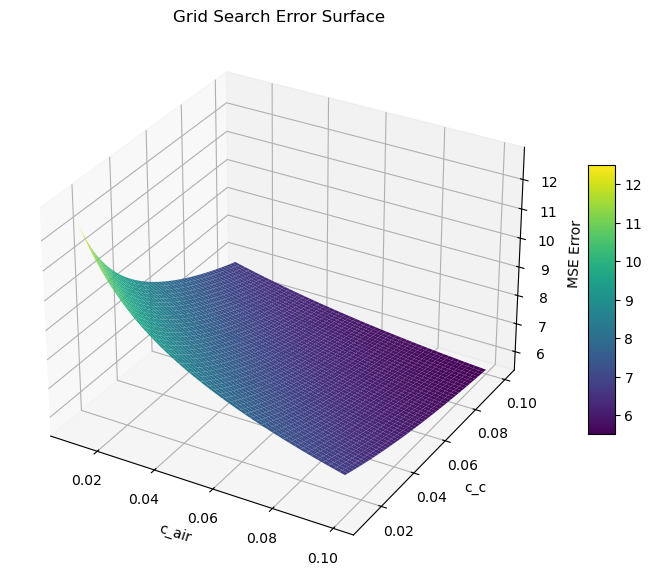

In [18]:
# Create meshgrid for plotting
C_air, C_c = np.meshgrid(c_air_list, c_c_list, indexing='ij')

# Plotting the 3D error surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(C_air, C_c, error_grid, cmap='viridis')

ax.set_xlabel('c_air')
ax.set_ylabel('c_c')
ax.set_zlabel('MSE Error')
ax.set_title('Grid Search Error Surface')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()
